In [ ]:
from datetime import datetime
name = "SANDHIYA S"
current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

print(f"Name: {name}")
print(f"Date and Time: {current_time}")


Name: SANDHIYA S
Date and Time: 2025-09-27 16:28:06


In [26]:
import pandas as pd
url = "https://files.consumerfinance.gov/ccdb/complaints.csv.zip"
df_full = pd.read_csv(url, compression='zip', low_memory=False, nrows=60000)
df = df_full.sample(50000, random_state=42)
df.head()


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
12628,2025-09-22,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MD,21117,NaN,NaN,Web,2025-09-22,In progress,Yes,NaN,16071089
37730,2019-11-14,Mortgage,Reverse mortgage,Struggling to pay mortgage,NaN,NaN,NaN,"Peer Advisors, LLC",FL,33147,NaN,NaN,Referral,2019-12-12,Closed with explanation,Yes,NaN,3439701
39991,2025-06-09,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",SC,29483,NaN,Consent not provided,Web,2025-06-09,Closed with explanation,Yes,NaN,13974556
8525,2025-04-21,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Received bad information about your loan,NaN,NaN,"Nelnet, Inc.",OH,43015,NaN,Consent not provided,Web,2025-04-21,Closed with explanation,Yes,NaN,13092598
8279,2025-09-23,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Personal information incorrect,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MI,48439,NaN,NaN,Web,2025-09-23,In progress,Yes,NaN,16128222


In [8]:
df = df[['Product', 'Consumer complaint narrative']].dropna()
target_map = {
    'Credit reporting, repair, or other': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}

df = df[df['Product'].isin(target_map.keys())]
df['label'] = df['Product'].map(target_map)
df = df[['Consumer complaint narrative', 'label']]
df = df.rename(columns={'Consumer complaint narrative': 'text'})
df.head()

,text,label
29542,I am filing this complaint to remove inaccurac...,1
109,"This complaint is against S & S Recovery , Inc...",1
39788,This company repeated calls the County of XXXX...,1
22013,Received collections letter on XXXX21. Says th...,1
971,"On XX/XX/19, I e-signed an Intent to Proceed n...",3


In [9]:
inv_map = {v: k for k, v in target_map.items()}


In [19]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(clean_text)

df[['text', 'clean_text']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,clean_text
29542,I am filing this complaint to remove inaccurac...,filing complaint remove inaccuracy credit repo...
109,"This complaint is against S & S Recovery , Inc...",complaint recovery inc publishing unauthorized...
39788,This company repeated calls the County of XXXX...,company repeated call county xxxx xxxx toll fr...
22013,Received collections letter on XXXX21. Says th...,received collection letter xxxx say creditor x...
971,"On XX/XX/19, I e-signed an Intent to Proceed n...",xxxx esigned intent proceed notice td bank mor...


In [21]:
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training size:", len(X_train))
print("Testing size:", len(X_test))


Training size: 936
Testing size: 235


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Train shape:", X_train_tfidf.shape)
print("Test shape:", X_test_tfidf.shape)


Train shape: (936, 5000)
Test shape: (235, 5000)


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(max_iter=200)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.97      0.98      0.98       179
           2       0.00      0.00      0.00         3
           3       0.89      0.89      0.89        53

    accuracy                           0.95       235
   macro avg       0.62      0.62      0.62       235
weighted avg       0.94      0.95      0.94       235



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


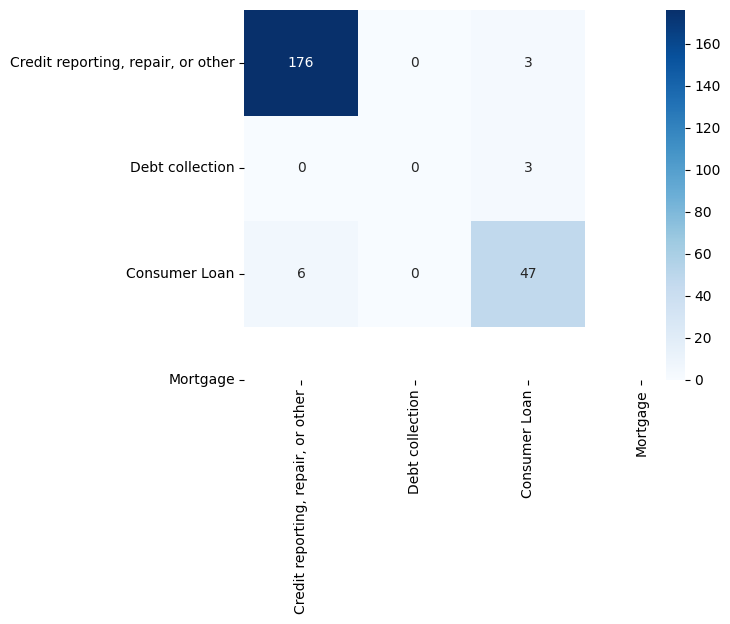

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_map.keys(), yticklabels=target_map.keys())
plt.show()



In [25]:
sample = [
    "I found incorrect entries in my credit report.",
    "The bank is harassing me for debt repayment."
]

preds = model.predict(vectorizer.transform(sample))
pred_labels = [inv_map[p] for p in preds]

print("Predictions:", pred_labels)


Predictions: ['Debt collection', 'Debt collection']
